In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, roc_auc_score

Using TensorFlow backend.


In [30]:
TRIALS = 5
FOLDS = 5
LAYERS = 2
MAX_POWER = 12
ACTIVATION = 'sigmoid'
LAST_ACTIVATION = 'softmax'

# Prepare training batches
input_data = pk.load(open('input_data4.pkl', 'rb'))
target_data = pk.load(open('target_data4.pkl', 'rb'))
model_input = np.array(input_data)
model_target = np.array(target_data)

print(model_input.shape)
print(model_target.shape)

#keys, values = np.unique(model_target, return_counts=True)
#values = (1 / values) / max((1 / values))
#class_weight = dict(zip(keys, values))
class_weight = dict(zip(np.arange(target_data[0].size), np.ones((target_data[0].size,))))

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
mms = MinMaxScaler()

layers = []
dimention = []
auc = []
kappa = []
for lay in range(1,LAYERS+1):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(f'layers: {lay}, nodes: {dim}')
        aucs = []
        kappas = []
        
        # Prepare k-fold training and test sets
        for trial in range(TRIALS):
            for train_index, test_index in skf.split(model_input, np.argmax(model_target, axis=1)):
                model_target[train_index.astype(int)]
                X_train, X_test = model_input[train_index], model_input[test_index]
                y_train, y_test = model_target[train_index], model_target[test_index]

                # Make the nn
                model = Sequential()
                model.add(Dense(dim, activation=ACTIVATION, input_shape=(model_input.shape[1],)))
                for l in range(lay-1):
                    model.add(Dense(dim, activation=ACTIVATION))
                model.add(Dense(model_target.shape[1], activation=LAST_ACTIVATION))
                model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                es = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0, restore_best_weights=True)]
                model.fit(X_train, y_train, epochs=1000, validation_split=0.25, callbacks=es, verbose=False)

                # Get the average auc and kappa for all affects and folds
                y_pred = model.predict(X_test, batch_size=1)
                for y_t, y_p in zip(y_test.T, y_pred.T):
                    y_t = y_t.astype(int)
                    y_p = mms.fit_transform(y_p.reshape(-1, 1))
                    aucs.append(roc_auc_score(y_t, y_p))
                    kappas.append(cohen_kappa_score(y_t, np.around(y_p)))
        
        layers.append(lay)
        dimention.append(dim)
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))
        print(f'auc: {auc[-1]}')
        print(f'kappa: {kappa[-1]}')

(3093, 107)
(3093, 4)
layers: 1, nodes: 1
auc: 0.7126698094255406
kappa: 0.15171590800721563
layers: 1, nodes: 2
auc: 0.7334822704927572
kappa: 0.17137235686468885
layers: 1, nodes: 4
auc: 0.7373235747097739
kappa: 0.1827124275552262
layers: 1, nodes: 8
auc: 0.737003117266286
kappa: 0.18177895655827847
layers: 1, nodes: 16
auc: 0.7380948725666439
kappa: 0.16794640142516787
layers: 1, nodes: 32
auc: 0.7373834009772974
kappa: 0.16441324866938395
layers: 1, nodes: 64
auc: 0.7326354601518266
kappa: 0.14420338523370888
layers: 1, nodes: 128
auc: 0.7347537784507169
kappa: 0.1512577650410989
layers: 1, nodes: 256
auc: 0.7397257803785188
kappa: 0.1432337779742766
layers: 1, nodes: 512
auc: 0.740058450004318
kappa: 0.14196801732238057
layers: 1, nodes: 1024
auc: 0.7407307783490414
kappa: 0.12572665595292945
layers: 1, nodes: 2048
auc: 0.7352320596464001
kappa: 0.12047252206052457
layers: 1, nodes: 4096
auc: 0.7284718884999336
kappa: 0.11242574243989496
layers: 2, nodes: 1


KeyboardInterrupt: 

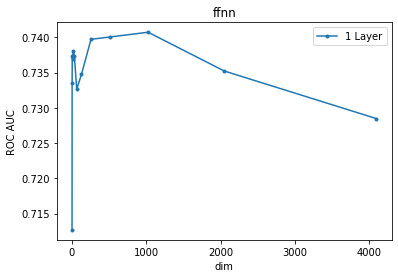

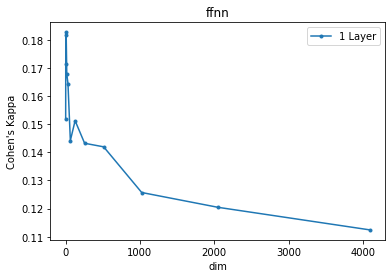

In [33]:
plt.figure()
for i in range(LAYERS-1):
    start = int(i*(MAX_POWER+1))
    end = int(i*(MAX_POWER+1)+MAX_POWER+1)
    plt.plot(dimention[start:end], auc[start:end], marker='.', label=f'{i+1} Layer')
plt.xlabel('dim')
plt.ylabel('ROC AUC')
plt.title('ffnn')
plt.legend()
plt.show()

plt.figure()
for i in range(LAYERS-1):
    start = int(i*(MAX_POWER+1))
    end = int(i*(MAX_POWER+1)+MAX_POWER+1)
    plt.plot(dimention[start:end], kappa[start:end], marker='.', label=f'{i+1} Layer')
plt.xlabel('dim')
plt.ylabel('Cohen\'s Kappa')
plt.title('ffnn')
plt.legend()
plt.show()